# MUSA650 Final Project Code

**Name:** Anne Evered

**Date:** May 2, 2020

**Description:**

This notebook contains code for analyses used in the final project for MUSA650. The goal of 
the proposed project is to develop a model that given an image, can detect if the building 
in that image likely has flood damage. The data consists of satellite images from Texas 
after Hurricane Harvey. The original source of the data can be found here <https://ieee-dataport.org/open-access/detecting-damaged-buildings-post-hurricane-satellite-imagery-based-customized>, but this notebook
uses a cleaned and labeled version of the data from this Kaggle page: https://www.kaggle.com/kmader/satellite-images-of-hurricane-damage

**To run:**

Load compressed data file using upload button in Google colab.

Note: because of the parameter sweep, this notebook can take several hours to run in entirey. Comment out that portion for faster runtime.

**Sources:**

This notebook extends https://www.kaggle.com/yuempark/satellite-images-of-hurricane-damage and
code from MUSA-650 Spring 2020 Course Lectures and Example Assignments.


## Load in Packages

In [4]:
from __future__ import print_function

!pip install tifffile

import pandas as pd
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
import numpy as np
import pickle

from os import listdir
from os.path import isfile, join

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from PIL import Image

import tifffile as tiff

from skimage.color import rgb2gray

from keras.optimizers import RMSprop

!pip3 install contextily
!pip3 install geopandas
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.geometry import Point
%matplotlib inline
import contextily as ctx

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Read in the Image File Paths

In [6]:
#UNCOMMENT TO UNZIP SATELLITE IMAGES
!unzip /content/satellite-images-of-hurricane-damage.zip

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/satellite-images-of-hurricane-damage/test_another/damage/._-95.631388_29.842959999999998.jpeg  
  inflating: satellite-images-of-hurricane-damage/test_another/damage/-95.557383_29.764859.jpeg  
  inflating: __MACOSX/satellite-images-of-hurricane-damage/test_another/damage/._-95.557383_29.764859.jpeg  
  inflating: satellite-images-of-hurricane-damage/test_another/damage/-95.574163_29.756742.jpeg  
  inflating: __MACOSX/satellite-images-of-hurricane-damage/test_another/damage/._-95.574163_29.756742.jpeg  
  inflating: satellite-images-of-hurricane-damage/test_another/damage/-95.632551_29.859847.jpeg  
  inflating: __MACOSX/satellite-images-of-hurricane-damage/test_another/damage/._-95.632551_29.859847.jpeg  
  inflating: satellite-images-of-hurricane-damage/test_another/damage/-95.2027_30.041414000000003.jpeg  
  inflating: __MACOSX/satellite-images-of-hurricane-damage/test_another/damage/._-95.2027_30.041414000000

In [0]:
#### Create Dataset of All Files #####

#define column names
column_names = ["label", "train_test_category", "image_name", "image_path"]

#Create empty dataframe
image_df = pd.DataFrame(columns = column_names)

all_files = []


dir_path = "/content/satellite-images-of-hurricane-damage/"

#Get all of the folders to look for files in
file_category_folders = [dir_path + f for f in listdir(dir_path) if ".DS_Store" not in f]
file_categories = [f for f in listdir(dir_path) if ".DS_Store" not in f]

#Get all of the files in subfolders and fill dataset wtih label, image name/path, and train/test category
for category, folder in zip(file_categories, file_category_folders):
    label_categories = [f for f in listdir(folder) if ".DS_Store" not in f]
    for label in label_categories:
        files_in_category = [f for f in listdir(join(folder, label)) if (isfile(join(folder, label, f)) and ".DS_Store" not in f)]
        all_files.extend([join(folder, label, file) for file in files_in_category])
        for file in files_in_category:
            image_df = image_df.append({'label' : label, 'train_test_category': category, 'image_name': file, 'image_path':join(folder, label, file)} , ignore_index=True)

In [8]:
image_df

,label,train_test_category,image_name,image_path
0,no_damage,validation_another,-95.626072_29.866551.jpeg,/content/satellite-images-of-hurricane-damage/...
1,no_damage,validation_another,-95.62578_29.860985.jpeg,/content/satellite-images-of-hurricane-damage/...
2,no_damage,validation_another,-95.17174399999999_29.514159000000003.jpeg,/content/satellite-images-of-hurricane-damage/...
3,no_damage,validation_another,-95.062917_29.830639.jpeg,/content/satellite-images-of-hurricane-damage/...
4,no_damage,validation_another,-95.631978_29.853457000000002.jpeg,/content/satellite-images-of-hurricane-damage/...
...,...,...,...,...
22995,damage,test_another,-95.175703_30.033993.jpeg,/content/satellite-images-of-hurricane-damage/...
22996,damage,test_another,-95.616789_29.764003999999996.jpeg,/content/satellite-images-of-hurricane-damage/...
22997,damage,test_another,-95.589701_29.75866.jpeg,/content/satellite-images-of-hurricane-damage/...
22998,damage,test_another,-95.669167_29.820797999999996.jpeg,/content/satellite-images-of-hurricane-damage/...


## Exploratory Data Analysis and Data Preparation

### Show Some Sample Images

In [0]:
#Open a sample image (with no damage label)
im_no_damage = Image.open(image_df.image_path[2])
im_no_damage.show()

In [0]:
#Open a sample image (with damage label)
im_damage = Image.open(image_df.image_path[22996])
im_damage.show()

### Get Details of a Sample Image

In [11]:
#Load a sample image to better understand some details about that image
!pip install opencv-python
import cv2

# read it in unchanged, to make sure we aren't losing any information
sample_image = cv2.imread(image_df['image_path'][0], cv2.IMREAD_UNCHANGED)

In [12]:
#Print out shape and pixel min/max details about sample image
print(np.shape(sample_image))
print(np.min(sample_image[:,:,:]))
print(np.max(sample_image[:,:,:]))

(128, 128, 3)
5
217


### Add and Visualize Location Details

In [13]:
#Add in location (lat and long) to dataframe by parsing out file name
image_df['location'] = image_df['image_name'].apply(lambda x: x.replace('.jpeg',''))
image_df['lon'] = image_df['location'].apply(lambda x: float(x.split('_')[0]))
image_df['lat'] = image_df['location'].apply(lambda x: float(x.split('_')[-1]))
image_df.head()

,label,train_test_category,image_name,image_path,location,lon,lat
0,no_damage,validation_another,-95.626072_29.866551.jpeg,/content/satellite-images-of-hurricane-damage/...,-95.626072_29.866551,-95.626072,29.866551
1,no_damage,validation_another,-95.62578_29.860985.jpeg,/content/satellite-images-of-hurricane-damage/...,-95.62578_29.860985,-95.625780,29.860985
2,no_damage,validation_another,-95.17174399999999_29.514159000000003.jpeg,/content/satellite-images-of-hurricane-damage/...,-95.17174399999999_29.514159000000003,-95.171744,29.514159
3,no_damage,validation_another,-95.062917_29.830639.jpeg,/content/satellite-images-of-hurricane-damage/...,-95.062917_29.830639,-95.062917,29.830639
4,no_damage,validation_another,-95.631978_29.853457000000002.jpeg,/content/satellite-images-of-hurricane-damage/...,-95.631978_29.853457000000002,-95.631978,29.853457


In [14]:
image_df['Coordinates'] = list(zip(image_df['lon'], image_df['lat']))
image_df['Coordinates'] = image_df['Coordinates'].apply(Point)

#Convert to geopandas dataframe
image_gpd = gpd.GeoDataFrame(image_df, geometry="Coordinates", crs={"init": "epsg:3857"})

image_gpd = image_gpd.to_crs(epsg=3857)

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [15]:
image_gpd.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

/usr/local/lib/python3.6/dist-packages/contextily/tile.py:629: UserWarning: The inferred zoom level of 25 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


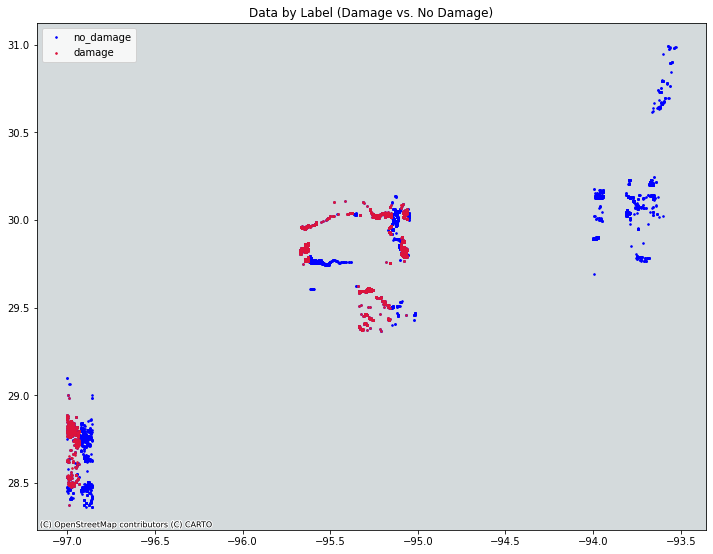

In [16]:
# create the axes
fig, ax = plt.subplots(figsize=(12, 12))

# plot a random sample of potholes
image_gpd[image_gpd["label"]=="damage"].plot(ax=ax, markersize=10, marker='.', c="blue", label = "no_damage")
image_gpd[image_gpd["label"]=="no_damage"].plot(ax=ax, markersize=10, marker='.', c="crimson", label = "damage") # NEW: use the sample() function

ax.legend()
ax.set_title('Data by Label (Damage vs. No Damage)')

# NEW: plot the basemap underneath
ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Positron) #crs=image_gpd.crs, 

# remove axis lines
#ax.set_axis_off()

### Get Unique Categories and Number of Images Per Category

In [17]:
image_gpd["train_test_category"].unique()
image_gpd["label"].unique()

array(['no_damage', 'damage'], dtype=object)

In [18]:
#Print the column names in image_df dataframe
image_df.columns

Index(['label', 'train_test_category', 'image_name', 'image_path', 'location',
       'lon', 'lat', 'Coordinates'],
      dtype='object')

In [19]:
#Get some statistics about the number of images in different label categories
image_df.groupby('label').count()['image_path']

label
damage       15000
no_damage     8000
Name: image_path, dtype: int64

In [20]:
#Get some statistics about the number of images in different train/test categories
image_df.groupby('train_test_category').count()['image_path']

train_test_category
test                   2000
test_another           9000
train_another         10000
validation_another     2000
Name: image_path, dtype: int64

In [21]:
#Get some statistics about the number of images in different train/test categories
image_df.count()

label                  23000
train_test_category    23000
image_name             23000
image_path             23000
location               23000
lon                    23000
lat                    23000
Coordinates            23000
dtype: int64

In [22]:
#Get some statistics about the number of images in different train/test categories
image_df.groupby(['train_test_category', 'label']).count()['image_path']

train_test_category  label    
test                 damage       1000
                     no_damage    1000
test_another         damage       8000
                     no_damage    1000
train_another        damage       5000
                     no_damage    5000
validation_another   damage       1000
                     no_damage    1000
Name: image_path, dtype: int64

### Split by Damage/No Damage and Show Examples

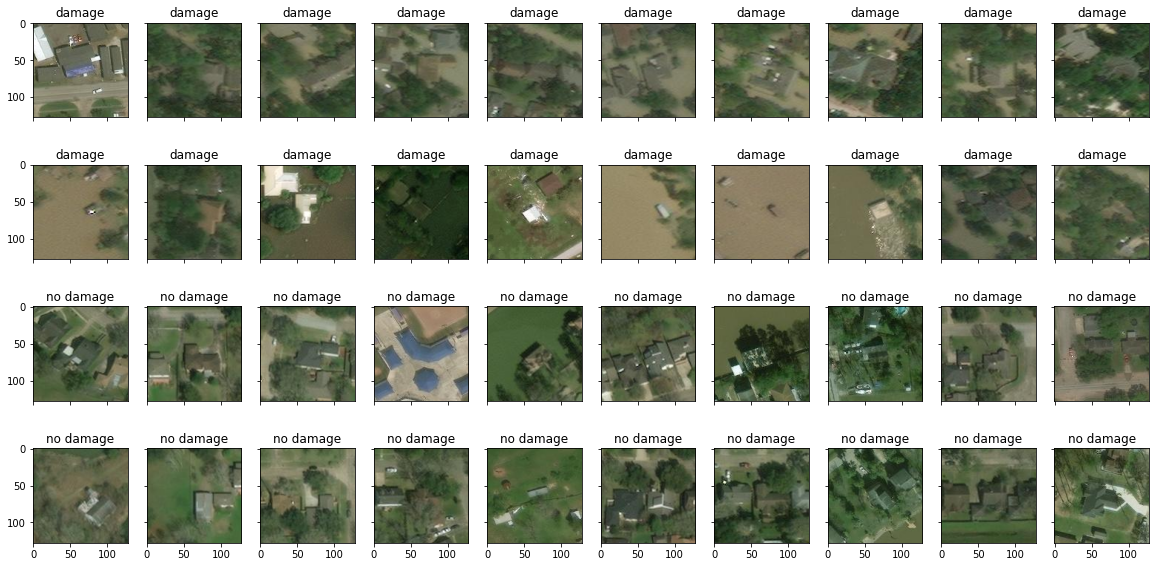

In [23]:
#Split images into damage/no damage label sets
image_df_dmg = image_df[image_df["label"]=="damage"].copy().reset_index()
image_df_nodmg = image_df[image_df["label"]=="no_damage"].copy().reset_index()


#Show 20 examples from each label category
fig, ax = plt.subplots(nrows=4, ncols=10, sharex=True, sharey=True, figsize=(20,10))

ax = ax.flatten()

for i in range(20):
    img = cv2.imread(image_df_dmg['image_path'][i], cv2.IMREAD_UNCHANGED)
    ax[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i].set_title('damage')
    
for i in range(20,40):
    img = cv2.imread(image_df_nodmg['image_path'][i], cv2.IMREAD_UNCHANGED)
    ax[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i].set_title('no damage')
    
plt.show()

### Image Loading and Pre-processing

In [0]:
# get the train-validation-test splits
image_df_train = image_df[image_df['train_test_category']=='train_another'].copy().reset_index()
image_df_val = image_df[image_df['train_test_category']=='validation_another'].copy().reset_index()
image_df_test = image_df[image_df['train_test_category']=='test_another'].copy().reset_index() #This should maybe be test (balanced)

image_df_test_balanced = image_df[image_df['train_test_category']=='test'].copy().reset_index()

In [0]:
#Get paths and labels per preset test/train/validatioin categories

# paths
train_path = image_df_train['image_path'].copy().values
val_path = image_df_val['image_path'].copy().values
test_path = image_df_test['image_path'].copy().values
test_balanced_path = image_df_test_balanced['image_path'].copy().values

# labels
train_labels = np.zeros(len(image_df_train), dtype=np.int8)
train_labels[image_df_train['label'].values=='damage'] = 1

val_labels = np.zeros(len(image_df_val), dtype=np.int8)
val_labels[image_df_val['label'].values=='damage'] = 1

test_labels = np.zeros(len(image_df_test), dtype=np.int8)
test_labels[image_df_test['label'].values=='damage'] = 1

test_balanced_labels = np.zeros(len(image_df_test_balanced), dtype=np.int8)
test_balanced_labels[image_df_test_balanced['label'].values=='damage'] = 1

labels_all = image_df_test['label'].values

In [26]:
!pip install imageio
from imageio import imread

#Read an initial image to get size of the feature vector
img = imread(image_df_train.image_path[0])
flat_image = img.flatten()

#Initialize data matrices for each of the 
dataMat_train = np.zeros([image_df_train.shape[0], flat_image.shape[0]])
dataMat_val = np.zeros([image_df_val.shape[0], flat_image.shape[0]])
dataMat_test = np.zeros([image_df_test.shape[0], flat_image.shape[0]])
dataMat_test_balanced = np.zeros([image_df_test_balanced.shape[0], flat_image.shape[0]])
#dataMat_all = np.zeros([image_df.shape[0], flat_image.shape[0]])

In [27]:
#Fill data matrix for each of the different datasets, also for an all data set (which will then use train-test split on )

#Fill the train data matrix with data for each of the images
print("Loading training data..")
for i, tmpRow in image_df_train.iterrows():
    img = imread(image_df_train.image_path[i])
    flat_image = img.flatten()
    dataMat_train[i,:] = flat_image

print("Loading validation data..")
#Fill the validation data matrix with data for each of the images
for i, tmpRow in image_df_val.iterrows():
    img = imread(image_df_val.image_path[i])
    flat_image = img.flatten()
    dataMat_val[i,:] = flat_image

print("Loading testing data..")
#Fill the test data matrix with data for each of the images
for i, tmpRow in image_df_test.iterrows():
    img = imread(image_df_test.image_path[i])
    flat_image = img.flatten()
    dataMat_test[i,:] = flat_image


print("Loading balanced testing data..")
#Fill the test balanced data matrix with data for each of the images
for i, tmpRow in image_df_test_balanced.iterrows():
    img = imread(image_df_test_balanced.image_path[i])
    flat_image = img.flatten()
    dataMat_test_balanced[i,:] = flat_image

#print("Loading all data..")
#Fill the data matrix (all images_) with data for each of the images
#for i, tmpRow in image_df.iterrows():
#    img = imread(image_df.image_path[i])
#    flat_image = img.flatten()
#    dataMat_all[i,:] = flat_image

Loading training data..
Loading validation data..
Loading testing data..
Loading balanced testing data..


In [28]:
dataMat_train

array([[ 69.,  82.,  65., ..., 160., 148., 132.],
       [104., 115.,  81., ...,  64.,  89.,  50.],
       [ 92.,  91.,  63., ...,  78.,  84.,  70.],
       ...,
       [ 99., 102.,  85., ..., 116., 115.,  97.],
       [142., 135., 106., ..., 209., 206., 197.],
       [151., 137., 110., ..., 131., 117.,  88.]])

In [29]:
dataMat_val

array([[ 65.,  67.,  53., ..., 138., 138., 110.],
       [ 38.,  56.,  32., ...,  56.,  58.,  44.],
       [ 96., 106.,  71., ...,  64.,  77.,  49.],
       ...,
       [ 47.,  62.,  43., ...,  69.,  97.,  57.],
       [ 63.,  95.,  56., ...,  42.,  51.,  32.],
       [ 80.,  79.,  59., ..., 108., 112.,  89.]])

In [30]:
dataMat_test

array([[ 95., 103.,  64., ...,  84., 108.,  76.],
       [158., 201., 156., ...,  91.,  94.,  63.],
       [175., 181., 171., ...,  93.,  99.,  65.],
       ...,
       [ 66.,  87.,  54., ..., 120., 123., 102.],
       [ 72.,  94.,  55., ...,  91., 102.,  62.],
       [ 57.,  74.,  38., ...,  57.,  83.,  46.]])

In [31]:
dataMat_test_balanced

array([[ 69.,  82.,  65., ..., 160., 148., 132.],
       [ 92.,  91.,  63., ...,  78.,  84.,  70.],
       [ 48.,  53.,  33., ...,  81.,  95.,  72.],
       ...,
       [ 47.,  62.,  43., ...,  69.,  97.,  57.],
       [122., 123.,  92., ...,  79.,  93.,  68.],
       [ 83.,  91.,  68., ..., 140., 137., 106.]])

In [0]:
#dataMat_all

## Supervised Methods

Consulted Week 8 DL_Basics1_SimpleMLP

### Additional Data Preparation

In [0]:
#Make copies of data matrices
X_train = np.copy(dataMat_train)
y_train = np.copy(train_labels)

X_test = np.copy(dataMat_test)
y_test = np.copy(test_labels)

X_val = np.copy(dataMat_val)
y_val = np.copy(val_labels)

X_test_balanced = np.copy(dataMat_test_balanced)
y_test_balanced = np.copy(test_balanced_labels)

#Make alls X values floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')
X_test_balanced = X_test_balanced.astype('float32')

#Normalize Data
X_train /= 255
X_test /= 255
X_val /= 255
X_test_balanced /= 255

In [0]:
#Reshape X data
X_train = X_train.reshape([-1, 128, 128, 3])

X_val = X_val.reshape([-1, 128, 128, 3])

X_test = X_test.reshape([-1, 128, 128, 3])

X_test_balanced = X_test_balanced.reshape([-1, 128, 128, 3])

In [0]:
# convert class vectors to binary class matrices
num_classes = 2

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_test_balanced = keras.utils.to_categorical(y_test_balanced, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

#### Function Definitions (used for multiple models)

In [0]:
#Define function for completing the fit and evaluate steps of different models

def fit_and_evaluate_model(model, X_train, X_test, X_val, y_train, y_test, y_val, batch_size, epochs):
    ''' Fits and evaluates model based on train, validation and data.
        Returns model development history. 
    '''
    #Fit
    history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          #validation_split=0.2) #,
          validation_data=(X_val, y_val))
    
    #Score
    score = model.evaluate(X_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    return history
    

In [0]:
def model_history_plots(history):
    ''' Plots a accuracy and loss graph by epoch based on model development history.
    '''
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [0]:
# Model Evaluation metrics 
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import classification_report
import sklearn.metrics as metrics

def confusion_matrix(model, y_test, X_test):
    ''' Calculates and prints confusion matrix and related metrics based
        on model and test data.
    '''
    y_pred_ohe = model.predict(X_test)  # shape=(n_samples, 12)
    y_pred_labels = np.argmax(y_pred_ohe, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)
    confusion_matrix = metrics.confusion_matrix(y_true=y_test_labels, y_pred=y_pred_labels)

    print('Accuracy Score : ' + str(accuracy_score(y_test_labels, y_pred_labels)))
    print('Precision Score : ' + str(precision_score(y_test_labels,y_pred_labels)))
    print('Recall Score : ' + str(recall_score(y_test_labels,y_pred_labels)))
    print('F1 Score : ' + str(f1_score(y_test_labels,y_pred_labels)))

    #Dummy Classifier Confusion matrix
    from sklearn.metrics import confusion_matrix
    print('Confusion Matrix : \n' + str(confusion_matrix(y_test_labels,y_pred_labels)))

### CNN Model 1 
(simpler model, 2 drop out layers, on RGB images)

In [0]:
# build model (1)
def create_model():

    np.random.seed(42)

    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(128, 128, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2))) #40x40
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(2, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(),
                  metrics=['accuracy'])
    
    return model

In [0]:
M1 = create_model()

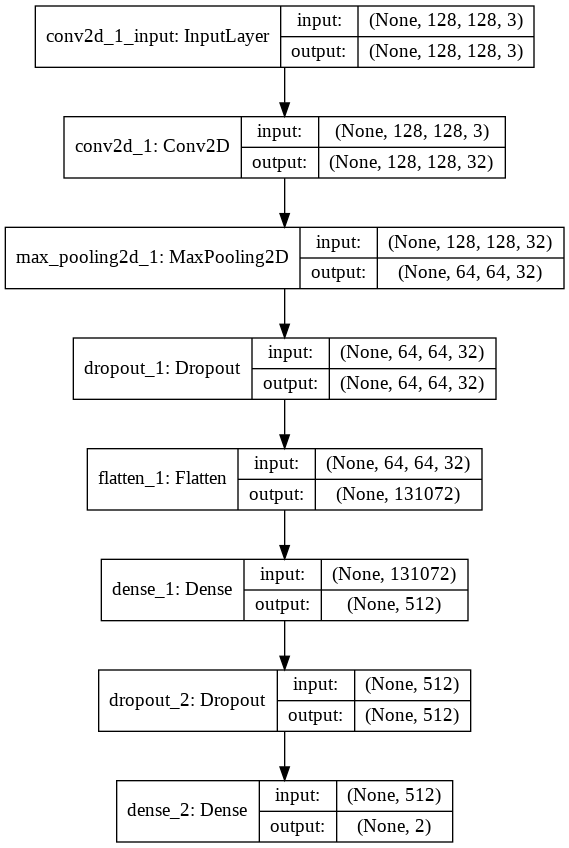

In [41]:
from keras.utils.vis_utils import plot_model
plot_model(M1, show_shapes=True)

In [42]:
history = fit_and_evaluate_model(M1, X_train, X_test, X_val, y_train, y_test, y_val, 32, 20)

Train on 10000 samples, validate on 2000 samples
Epoch 1/20
10000/10000 [==============================] - 14s 1ms/step - loss: 1.5160 - accuracy: 0.7465 - val_loss: 0.4068 - val_accuracy: 0.8325
Epoch 2/20
10000/10000 [==============================] - 8s 792us/step - loss: 0.3147 - accuracy: 0.8794 - val_loss: 0.2434 - val_accuracy: 0.9105
Epoch 3/20
10000/10000 [==============================] - 8s 789us/step - loss: 0.2516 - accuracy: 0.9051 - val_loss: 0.2775 - val_accuracy: 0.9085
Epoch 4/20
10000/10000 [==============================] - 8s 799us/step - loss: 0.2308 - accuracy: 0.9185 - val_loss: 0.3175 - val_accuracy: 0.8925
Epoch 5/20
10000/10000 [==============================] - 8s 801us/step - loss: 0.2049 - accuracy: 0.9279 - val_loss: 0.2697 - val_accuracy: 0.9075
Epoch 6/20
10000/10000 [==============================] - 8s 789us/step - loss: 0.1814 - accuracy: 0.9404 - val_loss: 0.2954 - val_accuracy: 0.9210
Epoch 7/20
10000/10000 [==============================] - 8s 785

In [43]:
confusion_matrix(M1, y_test, X_test)

Accuracy Score : 0.9508888888888889
Precision Score : 0.9636809815950921
Recall Score : 0.98175
F1 Score : 0.9726315789473684
Confusion Matrix : 
[[ 704  296]
 [ 146 7854]]


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


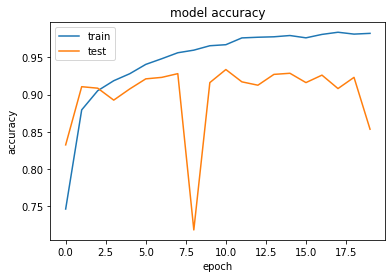

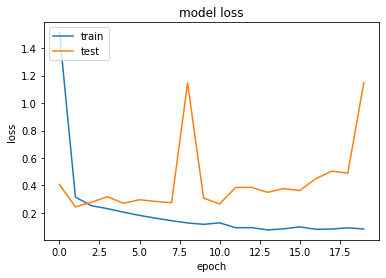

In [44]:
model_history_plots(history)

### CNN Model 2 
(single dense layer on gray-scale images)

In [0]:
from skimage.color import rgb2gray

#Convert data too grascale

# Initialize grayscale arrays
X_train_BW = np.zeros([X_train.shape[0],
                       X_train.shape[1],
                       X_train.shape[2]])

X_test_BW = np.zeros([X_test.shape[0],
                      X_test.shape[1],
                      X_test.shape[2]])

X_val_BW = np.zeros([X_val.shape[0],
                      X_val.shape[1],
                      X_val.shape[2]])

# convert RGB arrays to grayscale
for i in range(X_train.shape[0]):
  X_train_BW[i] = rgb2gray(X_train[i])

for i in range(X_test.shape[0]):
  X_test_BW[i] = rgb2gray(X_test[i])

for i in range(X_val.shape[0]):
  X_val_BW[i] = rgb2gray(X_val[i])

# flatten grayscale arrays
X_train_BW = X_train_BW.reshape(X_train_BW.shape[0],
                                X_train_BW.shape[1] * X_train_BW.shape[2])

X_test_BW = X_test_BW.reshape(X_test_BW.shape[0],
                              X_test_BW.shape[1] * X_test_BW.shape[2])

X_val_BW = X_val_BW.reshape(X_val_BW.shape[0],
                              X_val_BW.shape[1] * X_val_BW.shape[2])

In [46]:
print("X_train_BW shape:" + str(X_train_BW.shape))
print("X_test_BW shape:" + str(X_test_BW.shape))
print("X_val_BW shape:" + str(X_val_BW.shape))

print("y_train shape:" + str(y_train.shape))
print("y_test shape:" + str(y_test.shape))
print("y_val shape:" + str(y_train.shape))

X_train_BW shape:(10000, 16384)
X_test_BW shape:(9000, 16384)
X_val_BW shape:(2000, 16384)
y_train shape:(10000, 2)
y_test shape:(9000, 2)
y_val shape:(10000, 2)


In [47]:
M2 = Sequential()
M2.add(Dense(num_classes, activation='softmax', input_shape=(16384,)))

M2.summary()

M2.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(),
                  metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 2)                 32770     
Total params: 32,770
Trainable params: 32,770
Non-trainable params: 0
_________________________________________________________________


In [48]:
history = fit_and_evaluate_model(M2, X_train_BW, X_test_BW, X_val_BW, y_train, y_test, y_val, 32, 20)

Train on 10000 samples, validate on 2000 samples
Epoch 1/20
10000/10000 [==============================] - 1s 141us/step - loss: 2.8961 - accuracy: 0.5107 - val_loss: 2.2996 - val_accuracy: 0.5045
Epoch 2/20
10000/10000 [==============================] - 1s 137us/step - loss: 2.6505 - accuracy: 0.5297 - val_loss: 2.4421 - val_accuracy: 0.5335
Epoch 3/20
10000/10000 [==============================] - 1s 136us/step - loss: 2.5665 - accuracy: 0.5452 - val_loss: 2.4553 - val_accuracy: 0.5435
Epoch 4/20
10000/10000 [==============================] - 1s 138us/step - loss: 2.5626 - accuracy: 0.5539 - val_loss: 2.9488 - val_accuracy: 0.5175
Epoch 5/20
10000/10000 [==============================] - 1s 138us/step - loss: 2.4032 - accuracy: 0.5685 - val_loss: 3.3239 - val_accuracy: 0.5125
Epoch 6/20
10000/10000 [==============================] - 1s 138us/step - loss: 2.4450 - accuracy: 0.5639 - val_loss: 5.1381 - val_accuracy: 0.5065
Epoch 7/20
10000/10000 [==============================] - 1s 14

In [49]:
M2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 2)                 32770     
Total params: 32,770
Trainable params: 32,770
Non-trainable params: 0
_________________________________________________________________


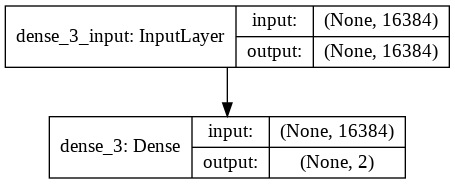

In [50]:
plot_model(M2, show_shapes=True)

In [55]:
confusion_matrix(M2, y_test, X_test_BW)

Accuracy Score : 0.8375555555555556
Precision Score : 0.9186731557377049
Recall Score : 0.896625
F1 Score : 0.907515182186235
Confusion Matrix : 
[[ 365  635]
 [ 827 7173]]


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


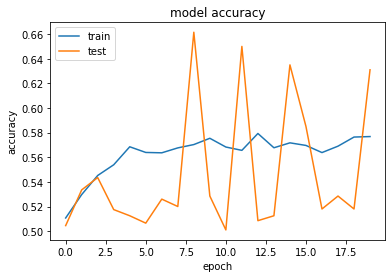

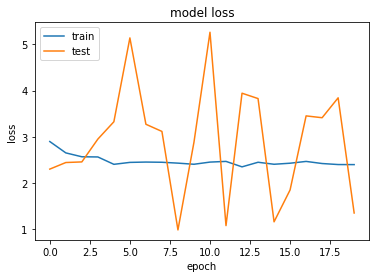

In [56]:
model_history_plots(history)

### CNN Model 3
 
(more complex model, on RGB images)

In [0]:
# build model (3)

def create_model():

  np.random.seed(42)

  M3 = Sequential()

  M3.add(Conv2D(32, (3, 3), padding='same', input_shape=(128, 128, 3), activation='relu'))
  M3.add(MaxPooling2D(pool_size=(2, 2))) #40x40
  M3.add(Dropout(0.25))

  M3.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
  M3.add(MaxPooling2D(pool_size=(2, 2))) #20x20
  M3.add(Dropout(0.25))

  M3.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
  M3.add(MaxPooling2D(pool_size=(2, 2))) #10x10
  M3.add(Dropout(0.25))

  M3.add(Conv2D(32, (10, 10), padding='same', activation='relu'))
  M3.add(MaxPooling2D(pool_size=(2, 2))) #5x5
  M3.add(Dropout(0.25))

  M3.add(Flatten())
  M3.add(Dense(512, activation='relu'))
  M3.add(Dropout(0.5))

  M3.add(Dense(2, activation='softmax'))

  M3.compile(loss='categorical_crossentropy',
                optimizer=RMSprop(),
                metrics=['accuracy'])
  
  return M3

In [0]:
M3 = create_model()

In [59]:
history = fit_and_evaluate_model(M3, X_train, X_test, X_val, y_train, y_test, y_val, batch_size = 32, epochs = 20)

Train on 10000 samples, validate on 2000 samples
Epoch 1/20
10000/10000 [==============================] - 5s 458us/step - loss: 0.6109 - accuracy: 0.6585 - val_loss: 0.3718 - val_accuracy: 0.8510
Epoch 2/20
10000/10000 [==============================] - 4s 424us/step - loss: 0.3063 - accuracy: 0.8676 - val_loss: 0.1928 - val_accuracy: 0.9145
Epoch 3/20
10000/10000 [==============================] - 4s 428us/step - loss: 0.2315 - accuracy: 0.9090 - val_loss: 0.3316 - val_accuracy: 0.9155
Epoch 4/20
10000/10000 [==============================] - 4s 430us/step - loss: 0.2213 - accuracy: 0.9190 - val_loss: 0.2172 - val_accuracy: 0.9180
Epoch 5/20
10000/10000 [==============================] - 4s 430us/step - loss: 0.2010 - accuracy: 0.9256 - val_loss: 0.3160 - val_accuracy: 0.8430
Epoch 6/20
10000/10000 [==============================] - 4s 429us/step - loss: 0.1786 - accuracy: 0.9332 - val_loss: 0.2213 - val_accuracy: 0.9365
Epoch 7/20
10000/10000 [==============================] - 4s 42

In [60]:
M3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)       

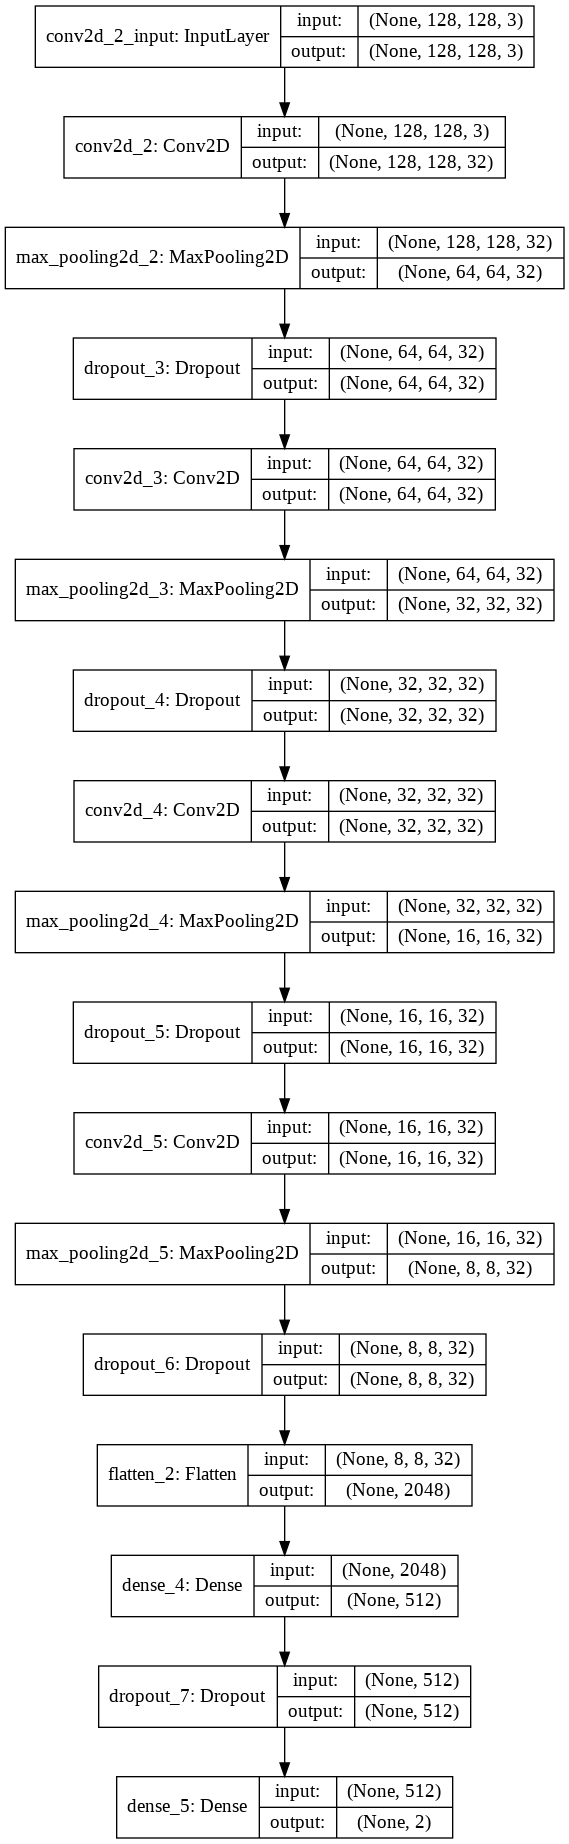

In [61]:
plot_model(M3, show_shapes=True)

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


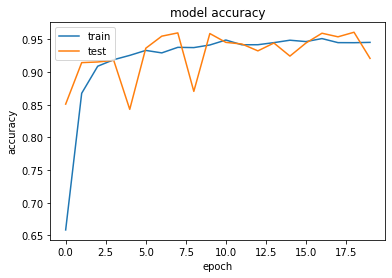

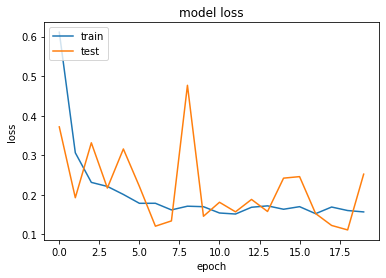

In [62]:
model_history_plots(history)

In [63]:
#Parameter sweep (because could not get GridSearch to work)

import itertools
epochs_options = [10, 20, 50]
batch_size_options = [32, 64, 128]

parameter_combinations = [(batch_size, epochs) for batch_size in batch_size_options for epochs in epochs_options]

best_combination = parameter_combinations[0]
best_combination_score = 0
scores = []

#Iterate through the combinations of parameters, train model and get history, and print 
# out loss and accuracy. Store the best combination and scores. 
for combination in parameter_combinations:
  print(combination)
  M3 = create_model()
  batch_size = combination[0]
  epochs = combination[1]
  history = M3.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          #validation_split=0.2) #,
          validation_data=(X_val, y_val))
    
  #Score
  score = M3.evaluate(X_test, y_test, verbose=0)
  print('Test loss:', score[0])
  print('Test accuracy:', score[1])
  scores.append(score[1])
  if score[1] > best_combination_score:
    best_combination = combination
    best_combination_score = score[1]


print("The best parameter combination is a batch size of " + str(best_combination[0]) + " and " + str(best_combination[1])  + " epochs, with a testing accuracy of " + str(score[1]))   


(32, 10)
Train on 10000 samples, validate on 2000 samples
Epoch 1/10
10000/10000 [==============================] - 5s 465us/step - loss: 0.6833 - accuracy: 0.6074 - val_loss: 0.5024 - val_accuracy: 0.7250
Epoch 2/10
10000/10000 [==============================] - 4s 427us/step - loss: 0.3758 - accuracy: 0.8432 - val_loss: 0.6652 - val_accuracy: 0.8045
Epoch 3/10
10000/10000 [==============================] - 4s 429us/step - loss: 0.2630 - accuracy: 0.8940 - val_loss: 0.2344 - val_accuracy: 0.9135
Epoch 4/10
10000/10000 [==============================] - 4s 432us/step - loss: 0.2243 - accuracy: 0.9091 - val_loss: 0.1981 - val_accuracy: 0.9195
Epoch 5/10
10000/10000 [==============================] - 4s 425us/step - loss: 0.2129 - accuracy: 0.9172 - val_loss: 0.2431 - val_accuracy: 0.9155
Epoch 6/10
10000/10000 [==============================] - 4s 427us/step - loss: 0.2028 - accuracy: 0.9277 - val_loss: 0.2319 - val_accuracy: 0.9255
Epoch 7/10
10000/10000 [==============================

Text(0.5, 1.0, 'Test Accuracy with Different Parameters')

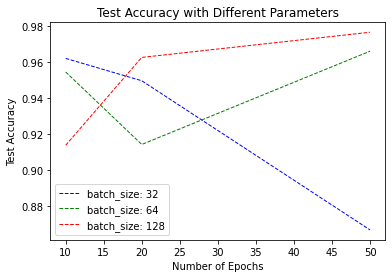

In [64]:
import matplotlib.pyplot as plt

#Graph the results of the parameter sweep

#Create a dataset showing the parameter options and the accuracy score
d = {'combinations': parameter_combinations[0:len(scores)], 'accuracy_score': scores}
parameter_test_df = pd.DataFrame(data=d)
parameter_test_df["batch_size"] = parameter_test_df["combinations"].apply(lambda x: x[0])
parameter_test_df["epochs"] = parameter_test_df["combinations"].apply(lambda x: x[1])

#Plot line for each batch_size showing accuracy by epoch
batch_df = parameter_test_df[parameter_test_df["batch_size"]==32]
plt.plot('epochs', 'accuracy_score', data=batch_df, marker='', color = 'blue', linewidth=1, linestyle='dashed', label='batch_size: 32')

batch_df = parameter_test_df[parameter_test_df["batch_size"]==64]
plt.plot('epochs', 'accuracy_score', data=batch_df, marker='', color = 'green', linewidth=1, linestyle='dashed', label='batch_size: 64')

batch_df = parameter_test_df[parameter_test_df["batch_size"]==128]
plt.plot('epochs', 'accuracy_score', data=batch_df, marker='', color = 'red', linewidth=1, linestyle='dashed', label='batch_size: 128')

plt.legend()

plt.ylabel('Test Accuracy')
plt.xlabel('Number of Epochs')
plt.title('Test Accuracy with Different Parameters')


In [65]:
parameter_test_df

,combinations,accuracy_score,batch_size,epochs
0,"(32, 10)",0.962111,32,10
1,"(32, 20)",0.949667,32,20
2,"(32, 50)",0.866667,32,50
3,"(64, 10)",0.954556,64,10
4,"(64, 20)",0.914222,64,20
5,"(64, 50)",0.966111,64,50
6,"(128, 10)",0.913778,128,10
7,"(128, 20)",0.962667,128,20
8,"(128, 50)",0.976667,128,50


#### Train/Test Best Model annd Calculate Metrics

In [0]:
best_batch_size = best_combination[0]
best_epoch_number = best_combination[1]

#For testing:
#best_batch_size = 32
#best_epoch_number = 10

In [67]:
#train model 3 with the best parameter combination
M3 = create_model()

history = fit_and_evaluate_model(M3, X_train, X_test, X_val, y_train, y_test, y_val, best_batch_size, best_epoch_number)

Train on 10000 samples, validate on 2000 samples
Epoch 1/50
10000/10000 [==============================] - 4s 370us/step - loss: 0.7191 - accuracy: 0.5538 - val_loss: 0.7260 - val_accuracy: 0.5000
Epoch 2/50
10000/10000 [==============================] - 3s 340us/step - loss: 0.6604 - accuracy: 0.6305 - val_loss: 1.1174 - val_accuracy: 0.5000
Epoch 3/50
10000/10000 [==============================] - 3s 339us/step - loss: 0.5987 - accuracy: 0.7099 - val_loss: 0.6550 - val_accuracy: 0.6530
Epoch 4/50
10000/10000 [==============================] - 3s 339us/step - loss: 0.4839 - accuracy: 0.7813 - val_loss: 0.4101 - val_accuracy: 0.8395
Epoch 5/50
10000/10000 [==============================] - 3s 338us/step - loss: 0.3613 - accuracy: 0.8396 - val_loss: 1.6680 - val_accuracy: 0.5205
Epoch 6/50
10000/10000 [==============================] - 3s 339us/step - loss: 0.3713 - accuracy: 0.8570 - val_loss: 0.3557 - val_accuracy: 0.8435
Epoch 7/50
10000/10000 [==============================] - 3s 33

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


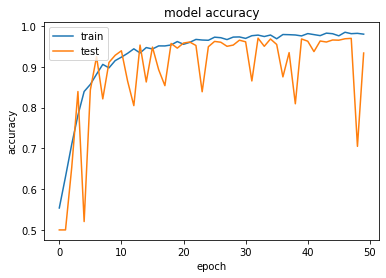

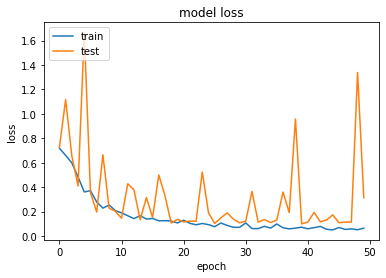

In [68]:
#make model history plots
model_history_plots(history)

In [69]:
#print confusion matrix and other metriics
confusion_matrix(M3, y_test, X_test)

Accuracy Score : 0.9301111111111111
Precision Score : 0.9931754315535929
Recall Score : 0.92775
F1 Score : 0.9593485426226329
Confusion Matrix : 
[[ 949   51]
 [ 578 7422]]


### Checking Images Misclassified (M3)

In [0]:
best_model = M3

In [71]:
#Referenced classmate HWs and MUSA650 class lectures for functions here

import collections, numpy

y_test_true_tmp = np.argmax(y_test, axis = 1)
print(y_test_true_tmp)
unique, counts = numpy.unique(test_labels, return_counts=True)
label_count = [8000, 1000] #HARD CODED THIS - MIGHT FIND BETTER WAY
label_Dict = dict(zip([0, 1], ["no damage","damage"]))

def eval_model_by_class(model, test_set):
  ''' Determine correct number and percentage of predictions per label class.
  '''
  y_test_pred_tmp = model.predict_classes(test_set)
  y_test_true = [label_Dict[x] for x in y_test_true_tmp]
  y_test_pred = [label_Dict[x] for x in y_test_pred_tmp]

  pred_df = pd.DataFrame({'y_true': y_test_true, 'y_pred': y_test_pred})
  pred_df['accurate_preds'] = pred_df.y_true == pred_df.y_pred
  pred_df = pred_df.groupby(['y_true']).sum().reset_index()
  pred_df['label_count'] = label_count
  pred_df['class_acc'] = pred_df.accurate_preds / pred_df.label_count
  pred_df = pred_df.sort_values(by = 'class_acc').reset_index()
  pred_df['overall_acc'] = sum(pred_df.accurate_preds) / sum(pred_df.label_count)
  pred_df = pred_df.sort_values('y_true').reset_index(drop = True)

  return(pred_df)

def find_wrong_preds(model, test_set):
  ''' Find wrong predictions.
  '''
  y_test_pred_tmp = model.predict_classes(test_set)

  y_test_true = [label_Dict[x] for x in y_test_true_tmp]
  y_test_pred = [label_Dict[x] for x in y_test_pred_tmp]

  pred_df = pd.DataFrame({'y_true': y_test_true, 'y_pred': y_test_pred})
  pred_df['accurate_preds'] = pred_df.y_true == pred_df.y_pred
  pred_df = pred_df.sort_values('y_true')

  return(pred_df)

[0 0 0 ... 1 1 1]


In [0]:
wrong_preds = find_wrong_preds(best_model, X_test)

In [73]:
wrong_preds

,y_true,y_pred,accurate_preds
4499,damage,damage,True
6008,damage,damage,True
6007,damage,damage,True
6006,damage,damage,True
6005,damage,no damage,False
...,...,...,...
660,no damage,no damage,True
659,no damage,no damage,True
658,no damage,no damage,True
671,no damage,no damage,True


In [0]:
#Find images of from each label class that were labeled incorrectly.

wrong_preds_actually_damage = wrong_preds[(wrong_preds.accurate_preds == False) &
                                  (wrong_preds.y_true == "damage")]

wrong_preds_actually_no_damage = wrong_preds[(wrong_preds.accurate_preds == False) &
                                     (wrong_preds.y_true == "no damage")]

This is an image labeled as having damage
It was mislabeled as having no damage


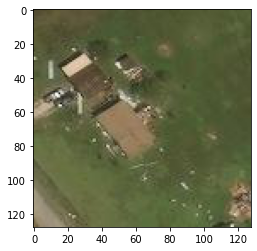

In [75]:
# Example 1
i = wrong_preds_actually_damage.index[0]

print("This is an image labeled as having " + str(label_Dict[y_test_true_tmp[i]]))
print("It was mislabeled as having " + str(wrong_preds_actually_damage.y_pred[i]))
plt.imshow(X_test[i]);

This is an image labeled as having no damage
It was mislabeled as having damage


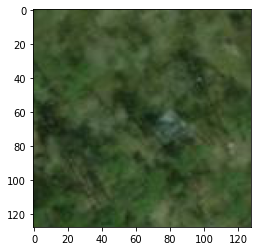

In [76]:
# Example 2
i = wrong_preds_actually_no_damage.index[0]

print("This is an image labeled as having " + str(label_Dict[y_test_true_tmp[i]]))
print("It was mislabeled as having " + str(wrong_preds_actually_no_damage.y_pred[i]))
plt.imshow(X_test[i]);

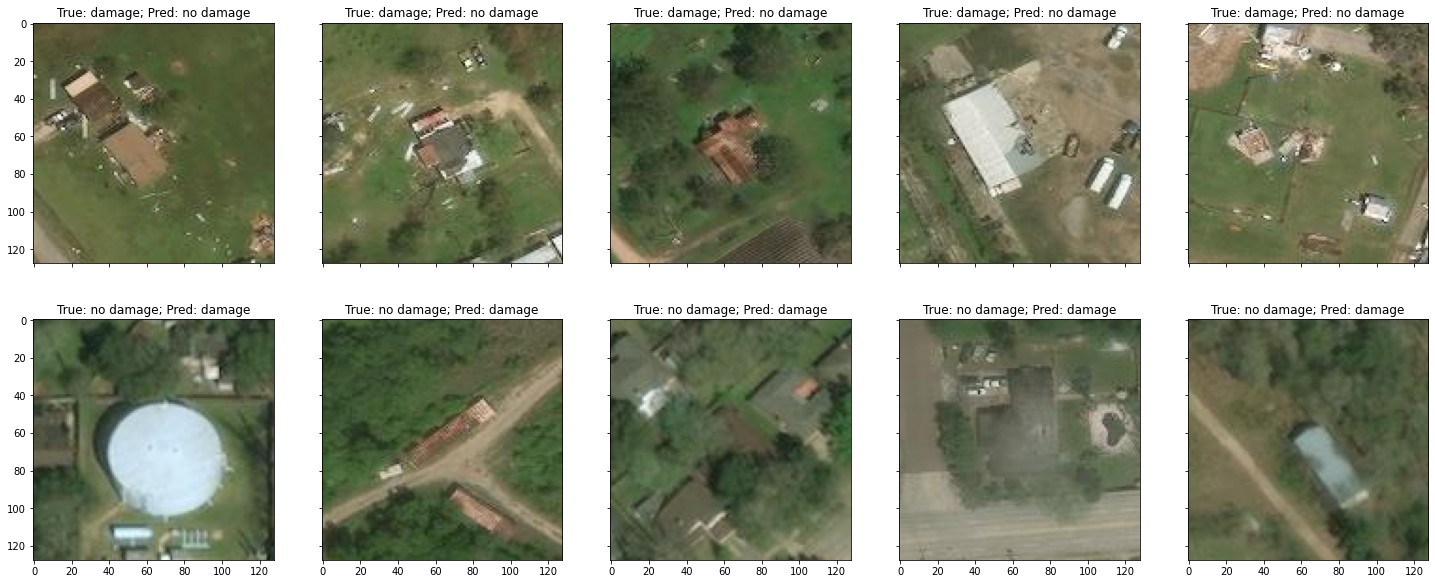

In [77]:
#Show more misclassification examples
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(25,10))

ax = ax.flatten()

for j in range(5):
    i = wrong_preds_actually_damage.index[j]
    ax[j].imshow(X_test[i])
    ax[j].set_title('True: damage; Pred: no damage')
    
for j in range(5, 10):
    i = wrong_preds_actually_no_damage.index[j]
    ax[j].imshow(X_test[i])
    ax[j].set_title('True: no damage; Pred: damage')
    
plt.show()

In [78]:
model_pred_df = eval_model_by_class(best_model, X_test)
model_pred_df

,index,y_true,accurate_preds,label_count,class_acc,overall_acc
0,0,damage,7422.0,8000,0.92775,0.930111
1,1,no damage,949.0,1000,0.94900,0.930111


### ROC Curve

In [0]:
from sklearn.metrics import roc_curve
y_pred = M3.predict_proba(X_test)[:,1]
#y_pred_ohe = M3.predict_proba(X_test)[:,1]
#y_pred_labels = np.argmax(y_pred_ohe, axis=1)
y_test_labels = np.argmax(y_test, axis=1)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_labels, y_pred)

In [80]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras

0.9828403125

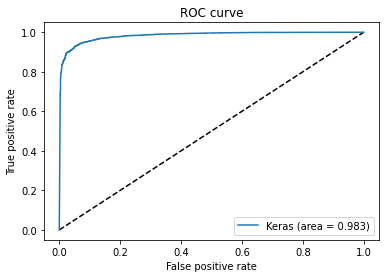

In [81]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [82]:
#Another Method
import sklearn
y_pred = M3.predict(X_test)
sklearn.metrics.roc_auc_score(y_test, y_pred)

0.9830189687499999

### Test Final Model with the Balanced Testing Data

Train on 10000 samples, validate on 2000 samples
Epoch 1/50
10000/10000 [==============================] - 4s 359us/step - loss: 0.7992 - accuracy: 0.5471 - val_loss: 0.7023 - val_accuracy: 0.5240
Epoch 2/50
10000/10000 [==============================] - 3s 336us/step - loss: 0.5518 - accuracy: 0.7375 - val_loss: 0.5047 - val_accuracy: 0.7550
Epoch 3/50
10000/10000 [==============================] - 3s 337us/step - loss: 0.3898 - accuracy: 0.8164 - val_loss: 0.3979 - val_accuracy: 0.8150
Epoch 4/50
10000/10000 [==============================] - 3s 337us/step - loss: 0.3104 - accuracy: 0.8646 - val_loss: 0.5127 - val_accuracy: 0.7950
Epoch 5/50
10000/10000 [==============================] - 3s 334us/step - loss: 0.2564 - accuracy: 0.8888 - val_loss: 0.3513 - val_accuracy: 0.8580
Epoch 6/50
10000/10000 [==============================] - 3s 337us/step - loss: 0.2279 - accuracy: 0.9075 - val_loss: 0.2792 - val_accuracy: 0.9060
Epoch 7/50
10000/10000 [==============================] - 3s 34

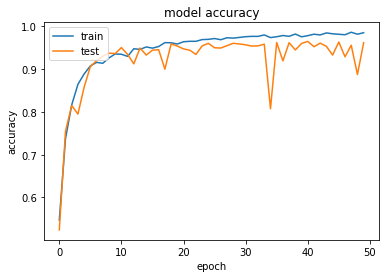

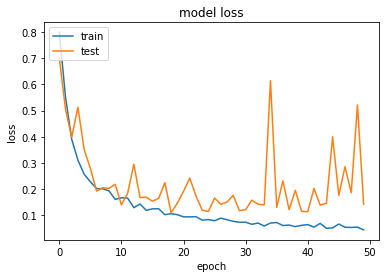

Accuracy Score : 0.9755
Precision Score : 0.9847094801223242
Recall Score : 0.966
F1 Score : 0.9752650176678445
Confusion Matrix : 
[[985  15]
 [ 34 966]]


In [83]:
#Train final model on the balanced testing data, as well.
M3 = create_model()
history = fit_and_evaluate_model(M3, X_train, X_test_balanced, X_val, y_train, y_test_balanced, y_val, best_batch_size, best_epoch_number)

model_history_plots(history)
confusion_matrix(M3, y_test_balanced, X_test_balanced)